# **Deteccion de fraudes de tarjetas de credito usando Machile Learning**

El presente proyecto realiza una comparacion de algunos algoritmos de Machine learning aplicados al conjunto de datos de clasficaicon de transacciones fraudulentas de tarjetas de credito.

Debido a la gran cantidad de tecnicas de machine learning y de procesamiento de grandes cantidades de conjunto de datos se hace complicado obtener resultados buenos de clasificacion.

Es por ello que se realizan comparaciones entre un conjunto de datos sin procesar y procesado con distitas tecnicas de machine learning. Ademas se implementa AutoEncoding para ver que tan eficiente es clasificando este tipo de dataset.


## Descripcion del Dataset

El conjunto de datos utilizado se puede encontrar [aqui.](https://www.kaggle.com/mlg-ulb/creditcardfraud)

Este dataset tiene 31 variables, de las cuales 28 estan reducidas dimensionalmente *(V1-V28)*, con el fin de transformar datos para proteger las identidades de las personas que han realizado las transacciones con tarjetas de credito.

Este dataset ha nacido capturando datos de transacciones bancarias de uno o mas bancos Europeos. No especifican que bancos o la cantidad de bancos. Aunque, podemos hacer la deduccion que ha sido un solo banco del continente Europeo debido a la estructura del dataset.


## Metodologia de Procesado y normalizacion



*   **Escalar valores:** Se escalan valores que tengan dispariedad en los rangos, mejorando el modelo de clasificacion
*   **Submuestreo aleatorio:** Se hace este submuestreo debido a la cantidad dispar de datos de una clase con respecto a otra.
*   **Construccion de un nuevo dataset:** Debido al submuestreo aleatorio nace la necesidad de construir un nuevo dataset con los datos seleccionados. Este conjunto de datos sera el definitivo.
*   **Particion del conjunto de datos:** Para poder problar los modelos de machine learning se hace una particion del conjunto de datos, escogiendo al azar 75% de los datos para entrenamiento y 25% para las pruebas. Estos fueron los mejores valores que he probado y que mejor resultado de clasificacion dan.



> Proximamente se analizaran datos atipicos en las variables y se les aplicara una metodologia de manejo de estos, con el fin de mejorar aun mas el modelo de machine learning.






# **Dependencias**

Las dependencias que se van a manejar en este proyecto son las siguientes


*   **Pandas:** Libreria que permite cargar y utilizar datasets y hacer operaciones de manera mas eficiente.
*   **Sklearn:** Ejecucion de los algoritmos de Preceptron multicapa, KNN, SVM, Random Forest, Regresion Logistica y Clasificador Uno vs el resto.
*   **TensorFlow - Keras:** Utilizacion para armar el autoenceder
*   **Numpy:** Manejo de matrices y operaciones de multiplicacion, y concatenacion
*   **MatPlotLib:** Permite la graficacion de datos
*   **Seaborn:** Permite la graficacion de datos tabulados de manera mas eficiente que matplotlib
*   **Tabulate:** Permite imprimir tablas de manera ordenada visualmente.







In [1]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers

from tensorflow.compat.v1.metrics import accuracy

from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing 

from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.manifold import TSNE

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches

from tabulate import tabulate
%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Cargar el dataset**

Permite cargar el dataset a la memoria, se utiliza pandas para leerlo. Esta funcion retorna un objeto de la clase DataFrame de pandas.

In [0]:
def load_dataset():
    dataset = pd.read_csv('/content/drive/My Drive/INTELIGENCIA ARTIFICIAL/II CORTE/PROYECTO/creditcard.csv')
    return dataset

dataset = load_dataset()

In [3]:
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# **Impresion Estadistica**

Para poder analizar el dataset debemos de mirar cuales son las caracteristicas estadisticas de cada variable, y que distribucion tienen, ademas de ver las correlaciones entre los diferentes parametros del conjunto de datos.

Lo anterior se hace con el fin de armar una metodologia mas clara para poder procesar el dataset, y que datos necesitan ser modificados y eliminados.

Para ello, se dibujan los graficos de barras que indican la distribucion del tiempo, del valor monetario de la transaccion y un grafico de distribucion de transacciones fraudulentas y no fraudulentas.

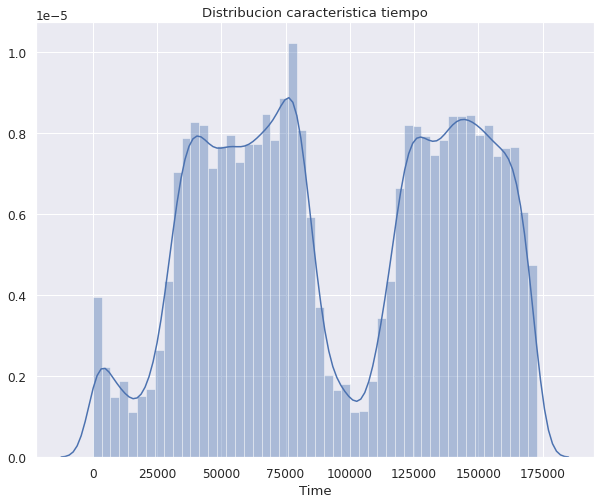

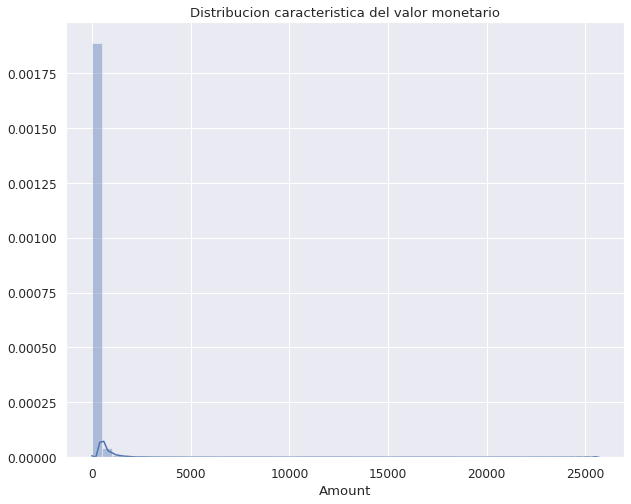

Hay 284315 transacciones no fraudulentas (99.827%) y 492 transacciones fraudulentas (0.173%).


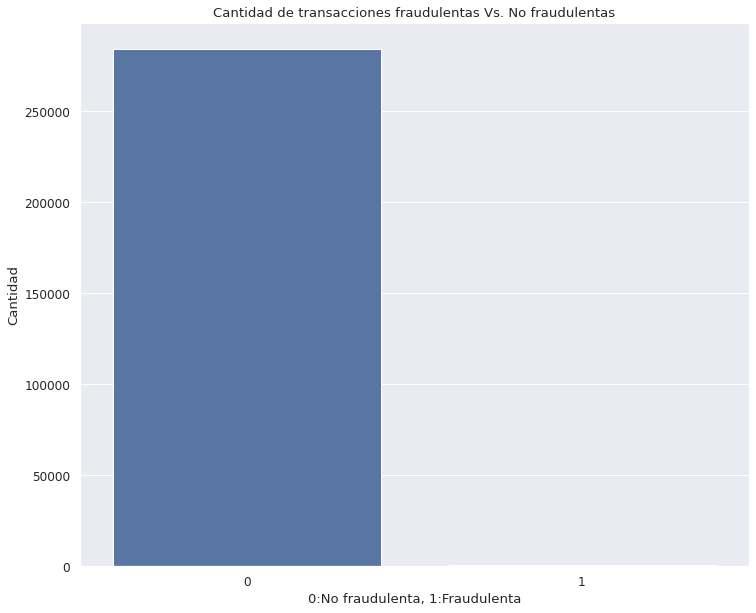

In [4]:
def graph_statistics(dataset):
    sns.set(font_scale=1.1)
    #Graph Time distribution
    plt.figure(figsize=(10,8))
    plt.title('Distribucion caracteristica tiempo')
    sns.distplot(dataset.Time)
    plt.show()

    #Graph Amount distribution
    plt.figure(figsize=(10,8))
    plt.title('Distribucion caracteristica del valor monetario')
    sns.distplot(dataset.Amount)
    plt.show()

    #Graph fraudulent vs not fraudulents transactions
    counts = dataset.Class.value_counts()
    normal = counts[0]
    fraudulent = counts[1]
    perc_normal = (normal/(normal+fraudulent))*100
    perc_fraudulent = (fraudulent/(normal+fraudulent))*100
    print('Hay {} transacciones no fraudulentas ({:.3f}%) y {} transacciones fraudulentas ({:.3f}%).'.format(normal, perc_normal, fraudulent, perc_fraudulent))
    
    plt.figure(figsize=(12,10))
    sns.barplot(x=counts.index, y=counts)
    plt.title('Cantidad de transacciones fraudulentas Vs. No fraudulentas')
    plt.ylabel('Cantidad')
    plt.xlabel('0:No fraudulenta, 1:Fraudulenta')
    plt.show()

graph_statistics(dataset)

# Matriz de correlacion

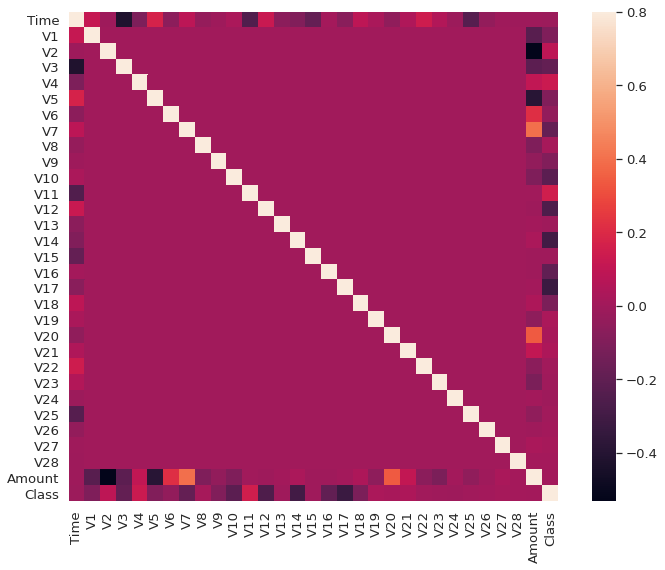

In [5]:
def correlation_matrix(dataset):
    corrmat = dataset.corr()
    sns.set(font_scale=1.2)
    fig = plt.figure(figsize=(12,9))
    sns.heatmap(corrmat, vmax = .8, square = True)
    plt.show()

correlation_matrix(dataset)

# **Ejecucion sin preprocesamiento**

Para tener un punto de comparacion y ver lo importante que es el preprocesamiento de un conjunto de datos en machile learning se procede a ejecutar los algoritmos en el dataset sin preprocesamiento.

## Modelos de ML a usar

Para este proyecto se utilizaran los siguientes modelos:


*   **Perceptron Multicapa:** Es el tipo mas basico de red neuronal. Para este caso de clasificacion funcionara perfectamente. La topologia de este perceptron multicapa consta de 31 neuronas de entrada, 2 capas ocultas, 3 neuronas en la capa y una neurona en la segunda capa. En la capa de salida solamente consta de una neurona. Como funcion de activacion se escoge ReLu para todas las capas. Como optimizador se utiliza el algoritmo Adam con un maximo de iteraciones de 2000 en caso de que el algoritmo no encuentre convergencia. Como semilla para generar los numeros pseudoaleatorios para generar los pesos en la fase de fordwass pass se escoge el numero 1. La constgante alpha para la regularizacion L2 se escoge el numero uno.
*   **Random Forest:** Es un algoritmo mas avanzado que los arboles de decision. Como parametros solo se le pasa `n_jobs`, el cual activa la ejecucion paralela utilizando todos los nucleos fisicos y logicos disponibles en el procesador.
*   **KNN:** K vecinos cercanos. Como parametro para escoger los n vecinos sera el nunmero 3.
*   **Linear SVC:** Debido a que el algoritmod e soporte de maquina vectorial puede demorar en clasificar, se utiliza un modelo derivado de este, mas sencillo y que puede clasificar igual o similar de bien. A esta tecnica le pasamos un clasificador Uno vs el Resto. Como generador de nuemos aleatorios se escoge el numero 0, y con una toleracia de error de `1x10^-5`. Cosmo se hizo en random forest, se activa la ejecucion paralela para utilizar varios hilos del procesador.
*   **Regresion Logistica:** Como parametros de la regresion logistica se utilizara un optimizador lbfgs con una penalizacion l2. Para genrar numeros pseudoaleatorios se ha escogido la semilla 0 y un maximo de iteraciones de 1000 en caso de que el algoritmo no converga.
*   **AutoEncoders:** Esta tecnica se explicara posteriormente y veremos los resultados. Es similar a un perceptron multicapa pero se utiliza para reducir la informacion de un conjunto de datos, facilitando la clasificacion de los datos. Tambien se utiliza para procesamiento y analisis de imagenes.




In [0]:
algs = [['Neural Network', MLPClassifier(hidden_layer_sizes=(3,1,), activation = 'relu'
                    ,solver='adam', alpha = 1, max_iter = 2000, random_state = 1)],
            ['Random Forest', RandomForestClassifier(n_jobs=-1)],
            ['KNN', KNeighborsClassifier(n_neighbors=3)],
            ['Support Machine Vector', OneVsRestClassifier(LinearSVC(random_state=0, tol=1e-05), n_jobs=-1)],
            ['Logistic Regression', LogisticRegression(penalty='l2', solver = 'lbfgs', random_state = 0, max_iter=1000)]]

In [0]:
columnas = ['Time']
for i in range(1,29):
    col = 'V' + str(i)
    columnas.append(col)
columnas.append('Amount')

y = dataset['Class']
X = pd.DataFrame(dataset, columns=columnas)

## Reduccion de dimensionalidad

Esta tecnica de procesamiento se usa cuando se tiene un dataset con demasiadas variables (dimensiones). Para este caso no se reducira la dimensionalidad del conjunto de datos, puesto que hay 28 variables que ya han sido manipuladas con esta tecnica (V1-V28).

Con la reduccion de dimensionalidad se puede graficar los datos mediante un diagrama de dispersion teniendo un dataset con mas de 3 dimensiones.

Teniendo en cuenta lo anterior la reduccion de dismensionalidad para este proyecto no se usara para transformar el conjunto de datos y disminuir las variables del mismo, sino para graficar los datos.

In [0]:
def reduce_dimensionality(X):
    X = TSNE(n_components=2, random_state=1).fit_transform(X)
    return X

def plot(X, y):
    plt.figure() 
    f, ax = plt.subplots(figsize=(24,16))

    blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
    red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)

    ax.scatter(X[:,0], X[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
    ax.set_title('t-SNE', fontsize=30)

    ax.grid(True)

    ax.legend(handles=[blue_patch, red_patch])

Hay varios algoritmos de reduccion de dimensionalidad, se utilizara en este caso t-SNE, implementado en la libreria `SKLearn`.

Hay otros algoritmos de reduccion de dimensionalidad como analisis principal de componentes (PCA) que tambien puede ayudar.

<Figure size 432x288 with 0 Axes>

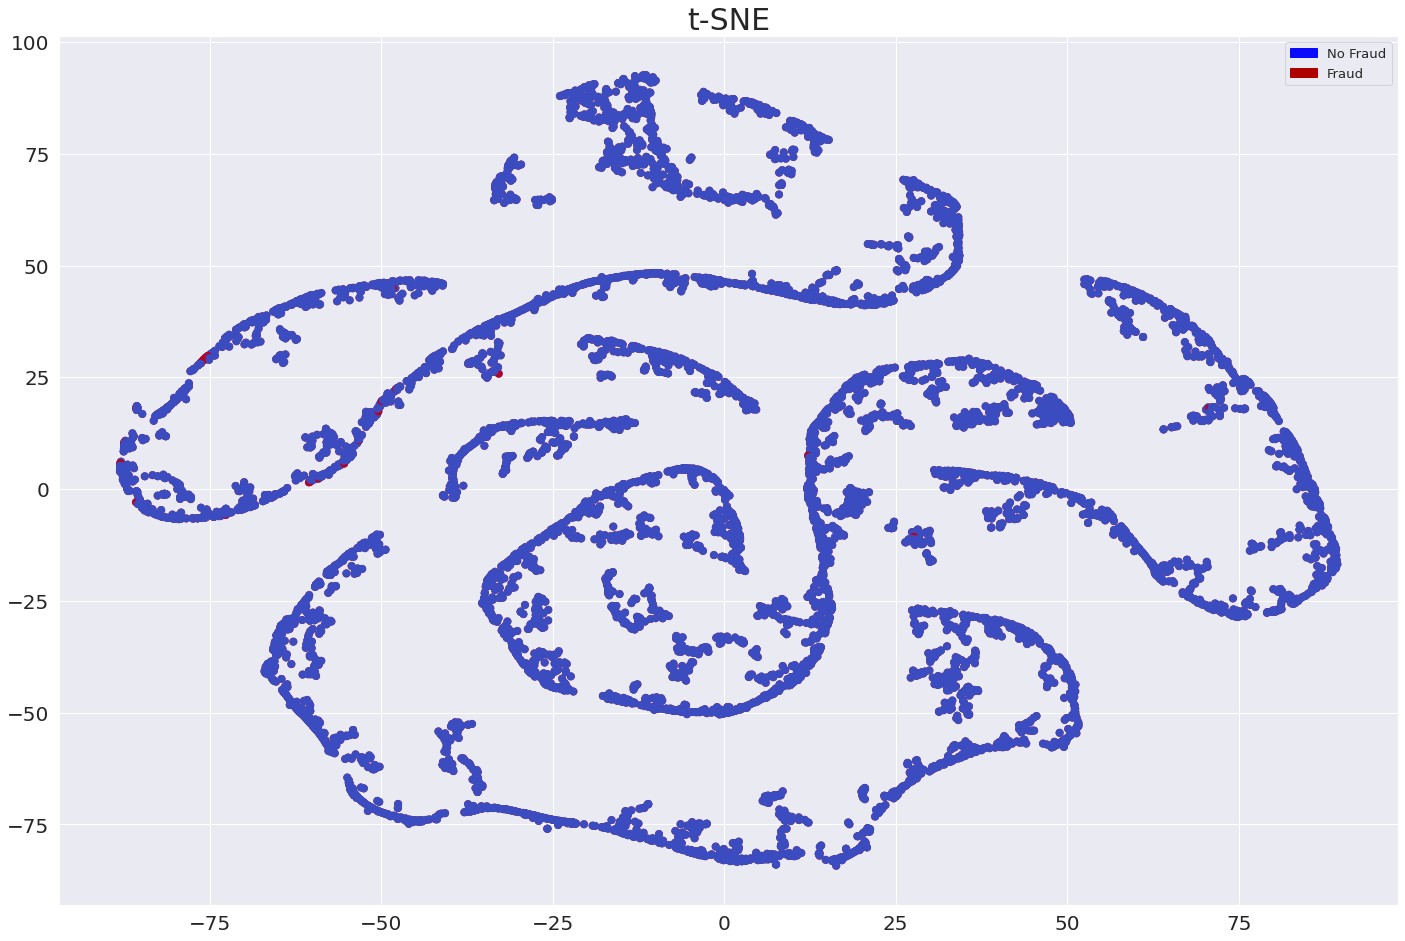

In [9]:
n = 8000
x_reduced = reduce_dimensionality(X[:n])
plot(x_reduced, y[:n])

Se puede observar en el grafico anterior que no se ve claramente los 2 clusteres, correspondientes a cada clase (Fraudulento y no fraudulento), por lo que es necesario hacer un procesamiento y reduccion de dimensionalidad.

## Particion del dataset

Para poder probar los modelos correctamente se hace un proceso de split o particion basica del dataset, hay otros procesos de aprticion comop la validacion cruzada. Para este proyecto vamos a partir el conjunto de datos utilizando el 75% de los datos para entrenamiento y el 25% restante para pruebas.

In [0]:
def split_dataset(X, y, test_size = 0.25, random_state = 1):
    X_train, X_test, y_train, y_test=train_test_split(X, y, 
                                                      test_size = test_size, 
                                                      random_state = random_state, 
                                                      shuffle=True)
    return X_train, X_test, y_train, y_test

## Dibujar la matrices de confusion

Para porder ver la matriz de confusion se utiliza matplotlib y sea born para graficar de manera visual el resultado de la matriz de confusion.

In [0]:
def draw_matrix_confusion(yTest, yPred, subplot, name, measures):
    LABELS = ['No Fraude', 'Fraude'] 
    conf_matrix = metrics.confusion_matrix(yTest, yPred) 
    sns.set(font_scale=2)
    ax = plt.subplot(3, 2, subplot)

    sns.heatmap(conf_matrix, xticklabels = LABELS,  
                yticklabels = LABELS, annot = True, fmt ="d"); 
    plt.title(name, fontsize=20, fontweight='bold') 
    plt.ylabel('Clase verdadera', fontsize=20, fontweight='bold') 
    plt.xlabel('Clase predicha\nROC-AUC: {}'.format(measures[-1]), fontsize=20, fontweight='bold') 
    return conf_matrix

## Calculo de medidas de desempeño

En este proyecto se calculan las medidas de desempeño para algoritmos de ML de clasificacion. En este proyecto se utilizara la matriz de confusion para calculas las siguientes medidas:

*   Accuracy: Promedio de los que ha clasificado correctamente
*   Recall
*   F1-Score
*   ROC-AUC: Area bajo la curva. Indica verdaderamente si que han bueno ha clasificado.

La desventaja de estas medidas es que no muestran verdaderamente si el modelo esta clasfiicando bien o mal. Este tipo de puntajes de desempeño no muestra un valor real cuando se tienen datos desbalanceados. Es por ello que, acompañado con estas medidas de desempeño se utilizara para evaluar el modelo la matriz de confusion.





In [0]:
def calculate_measures(y_test, yPred):
    acc = metrics.accuracy_score(y_test, yPred)
    prec = metrics.precision_score(y_test, yPred, average='micro')
    rec = metrics.recall_score(y_test, yPred, average='micro')
    f1 = metrics.f1_score(y_test, yPred, average='weighted', labels=np.unique(yPred))
    roc_auc = metrics.roc_auc_score(y_test, yPred)
    #MCC = metrics.matthews_corrcoef(y_test, yPred)
    return acc, prec, rec, f1, roc_auc


## Entrenamiento

Para poder entrenar todos los modelos de ML se utiliza la presente funcion.

Esta consta de un codigo en el cual se extraen los datos que se van a utilizar de entrenamiento y de pruebas, ademas, verfica si el clasificador es un autoencoder (Luego explicare que es), si no es un autoencoder procede a entrenar el modelo y predecir los valores utilizando las funciones `fit` y `predict` de `SkLearn`.

In [0]:
def make_machine_learning(X, y, classifier, auto_enc = False):
    
    X_train, X_test, y_train, y_test = split_dataset(X, y, random_state=1, test_size = 0.25)

    if isinstance(classifier, Model):
        classifier.fit(X_train, X_train, 
                        batch_size = 256, 
                        epochs = 100, 
                        shuffle = True, 
                        validation_split = 0.20)
        predictions = classifier.predict(X_test)
        mse = np.mean(np.power(X_test - predictions, 2), axis=1)
        error_df = pd.DataFrame({'reconstruction_error': mse,
                                'true_class': y_test})
        threshold = 1.68
        yPred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
    else:
        classifier.fit(X_train, y_train)
        yPred = classifier.predict(X_test)

    measures = calculate_measures(y_test, yPred)

    return X_train, X_test, y_train, y_test, measures, yPred

Entrenando modelo con la tecnica Neural Network
Dibujando matrices de confusion para Neural Network
Entrenando modelo con la tecnica Random Forest
Dibujando matrices de confusion para Random Forest
Entrenando modelo con la tecnica KNN
Dibujando matrices de confusion para KNN
Entrenando modelo con la tecnica Support Machine Vector
Dibujando matrices de confusion para Support Machine Vector
Entrenando modelo con la tecnica Logistic Regression
Dibujando matrices de confusion para Logistic Regression




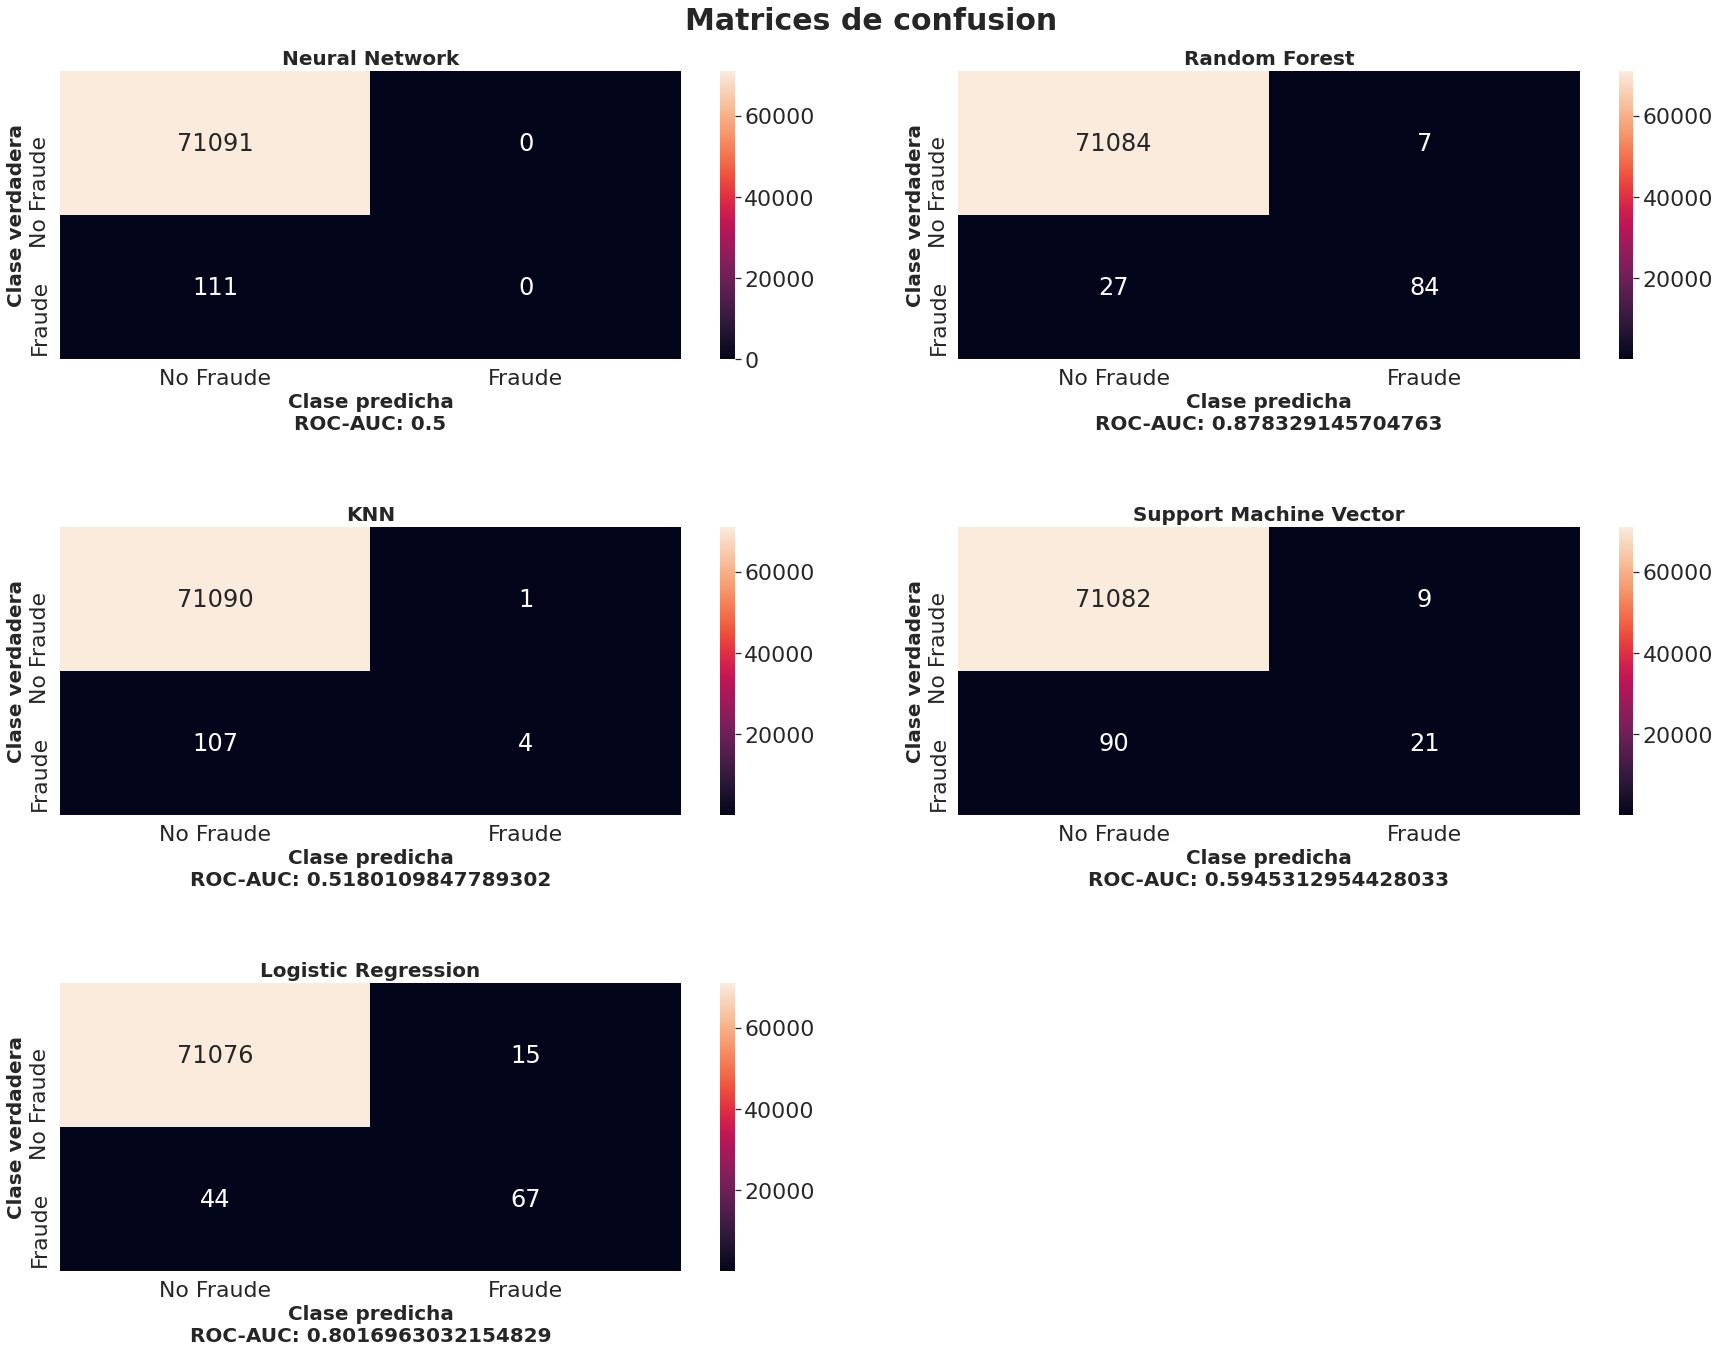


Method                    Accuracy    Precision    Recall    f1 Score    ROC AUC
----------------------  ----------  -----------  --------  ----------  ---------
Neural Network            0.998441     0.998441  0.998441    0.99922    0.5
Random Forest             0.999522     0.999522  0.999522    0.999499   0.878329
KNN                       0.998483     0.998483  0.998483    0.997791   0.518011
Support Machine Vector    0.99861      0.99861   0.99861     0.998211   0.594531
Logistic Regression       0.999171     0.999171  0.999171    0.999109   0.801696


In [14]:
def train(X, y):
    fig = plt.figure(figsize =(26, 20))
    fig.suptitle('Matrices de confusion', fontsize=30, fontweight='bold')
    performance_measures = []   
    i = 1
    for name, classifier in algs:
        tup = []
        print('Entrenando modelo con la tecnica ' + name)
        X_train, X_test, y_train, y_test, measures, yPred = make_machine_learning(X, y, classifier)
        tup.append(name)
        for mea in measures:
            tup.append(mea)
        performance_measures.append(tup)
        print('Dibujando matrices de confusion para ' + name)
        confusion_matrix = draw_matrix_confusion(y_test, yPred, i, name, measures)
        i += 1
    print('\n')
    fig.tight_layout(pad=3.0)
    plt.show()
    print('')
    print(tabulate(performance_measures, headers=['Method', 'Accuracy', 'Precision', 'Recall', 'f1 Score', 'ROC AUC']))

train(X, y)

Como podemos ver en los resultados anteriores, aunque el accuracy haya dado por encima del 99% no significa que los modelos esten clasificando correctamente. Para verificarlo verdaderamente es cuestion de mirar la matriz de confusion.

Teniendo en cuenta lo anterior, todos los modelos les cuesta trabajo clasificar transacciones fraudulentas por la poca cantidad de datos que hay a esta clase por el desbalanceo de datos. Lo anterior produce un fenomeno llamado OverFitting, un sobreentrenamiento de datos disparen por clase, por lo que los modelos no son capaces de clasificar transacciones fraudulentas debido a la gran cantidad de datos de la clase contraria.

Por lo tanto, el modelo de prediccion se puede mejorar bastante aplicando tecnicas de preprocesamiento y normalizacion del conjunto de datos respectivo.

# **Procesamiento y normalizacion del dataset**



## Escalar valores

Debido a que algunos valores no tienen un rango fijo o tienen valores muy altos y muy bajos (Distribucion exponencial) y se tienen pocos rangos de valores. Este caso se cumple para el Monto y para el tiempo.

In [0]:
'''
Normalizar valores utilizando StandarScaler de SKLEARN
'''
def normalize_data(X):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(X)
    flat_list = [item for sublist in scaled_data.tolist() for item in sublist]
    scaled = pd.Series(flat_list)

    return scaled

'''
Metodo para escalar
'''
def scaling(dataset):
    #scaling time
    scaled_time = normalize_data(dataset[['Time']])
    
    #scaling the amount column
    scaled_amount = normalize_data(dataset[['Amount']])

    return scaled_time, scaled_amount

## Random Under-Sampling

Debido un gran desbalanceo de datos de transacciones fraudulentas y no fraudulentas puede provocar que los modelos de prediccion se sobre entrenen y no puedan predecir correctamente las transacciones fraudulentas.

Hay distintas tecnicas para lograr una aprticiond e datos con datos de clases balanceadas. La tecnica que se va a utilizar es la de Random UnderSampling (Muestreo aleatorio), tambien existe la validacion cruzada (K-folds).

La primera tecnica es la mas sencilla de hacer, y consiste en escoger todos los datos de la clase que tenga menos muestras, y de las clases contrarias escoger aleatoriamente datos hasta llegar al numero de muestras de la clase la cual tiene menos datos. Esta tecnica funciona para n cantidad de clases.

In [0]:
def preprocessing_dataset(dataset):
    #ESCALAR VALORES
    scaled_time, scaled_amount = scaling(dataset)
    dataset = pd.concat([dataset, scaled_amount.rename('scaled_amount'), scaled_time.rename('scaled_time')], axis=1)
    # Eliminar valores antiguos, seran reemplazados por los valores escalados
    dataset.drop(['Amount', 'Time'], axis=1, inplace=True)

    #RANDOM UNDER-SAMPLING
    dataset_fraud = dataset[dataset['Class'] == 1]
    dataset_fraud_x = dataset_fraud.drop(['Class'], axis = 1)
    dataset_fraud_y = dataset_fraud['Class']

    is_not_fraud = dataset['Class'] == 0

    dataset_not_fraud = dataset[is_not_fraud].sample(n=len(dataset_fraud_x), replace = True, random_state = 1)
    dataset_not_fraud_x = dataset_not_fraud.drop(['Class'], axis=1)
    dataset_not_fraud_y = dataset_not_fraud['Class']
    
    #Concatenar 
    X = np.concatenate((dataset_not_fraud_x.values, dataset_fraud_x.values))
    y = np.concatenate((dataset_not_fraud_y.values, dataset_fraud_y.values))

    fraud = pd.concat([dataset_not_fraud_x, dataset_fraud_x])
    not_fraud = pd.concat([dataset_not_fraud_y, dataset_fraud_y])
    dataset = pd.concat([fraud, not_fraud], axis = 1)
    print(dataset)
    return X, y, dataset

Ejecutamos el preoprocesamiento completo y posteriormente graficamos el numero de datos por cada clase para verificar que el submuestreo aleatorio se ha realizado correctamente.

              V1        V2        V3  ...  scaled_amount  scaled_time  Class
128297 -0.433654  1.054817  1.702420  ...      -0.346073    -0.340061      0
267816  1.940544 -0.208672 -0.064282  ...      -0.311289     1.434637      0
73527  -0.361282  0.824714  1.979199  ...      -0.317287    -0.834775      0
117827  1.097337 -0.760035  0.582568  ...      -0.233487    -0.420776      0
21526   0.537376 -1.200021  0.793836  ...       0.962141    -1.328584      0
...          ...       ...       ...  ...            ...          ...    ...
279863 -1.927883  1.125653 -4.518331  ...       1.206024     1.565196      1
280143  1.378559  1.289381 -5.004247  ...      -0.350191     1.569513      1
280149 -0.676143  1.126366 -2.213700  ...      -0.041818     1.569597      1
281144 -3.113832  0.585864 -5.399730  ...       0.626302     1.582548      1
281674  1.991976  0.158476 -2.583441  ...      -0.183191     1.590592      1

[984 rows x 31 columns]


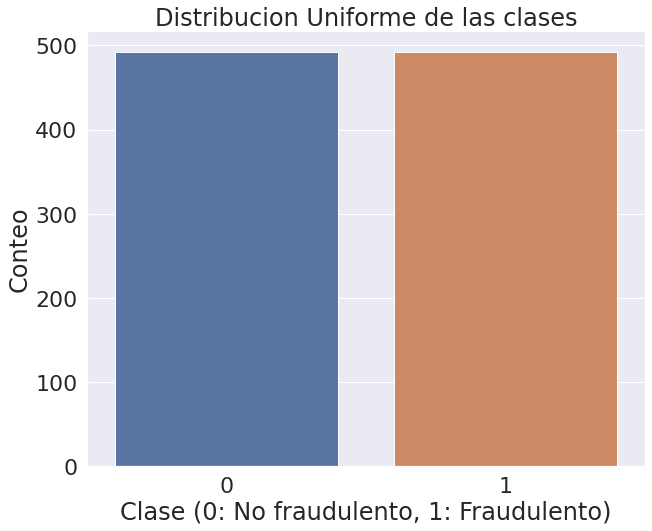

In [17]:
X, y, dataset = preprocessing_dataset(dataset)    
#Plot class
fig = plt.figure(figsize=(10,8))
sns.countplot('Class', data=dataset)
plt.title('Distribucion Uniforme de las clases')
plt.xlabel('Clase (0: No fraudulento, 1: Fraudulento)')
plt.ylabel('Conteo')
plt.show()

Para ver si hay un resultado claro haciendo procesamiento sobre el conjunto de datos se hace de nuevo uan reduccion de dimensionalidad para poder graficar los datos y ver si hay clusteres definidos.

<Figure size 432x288 with 0 Axes>

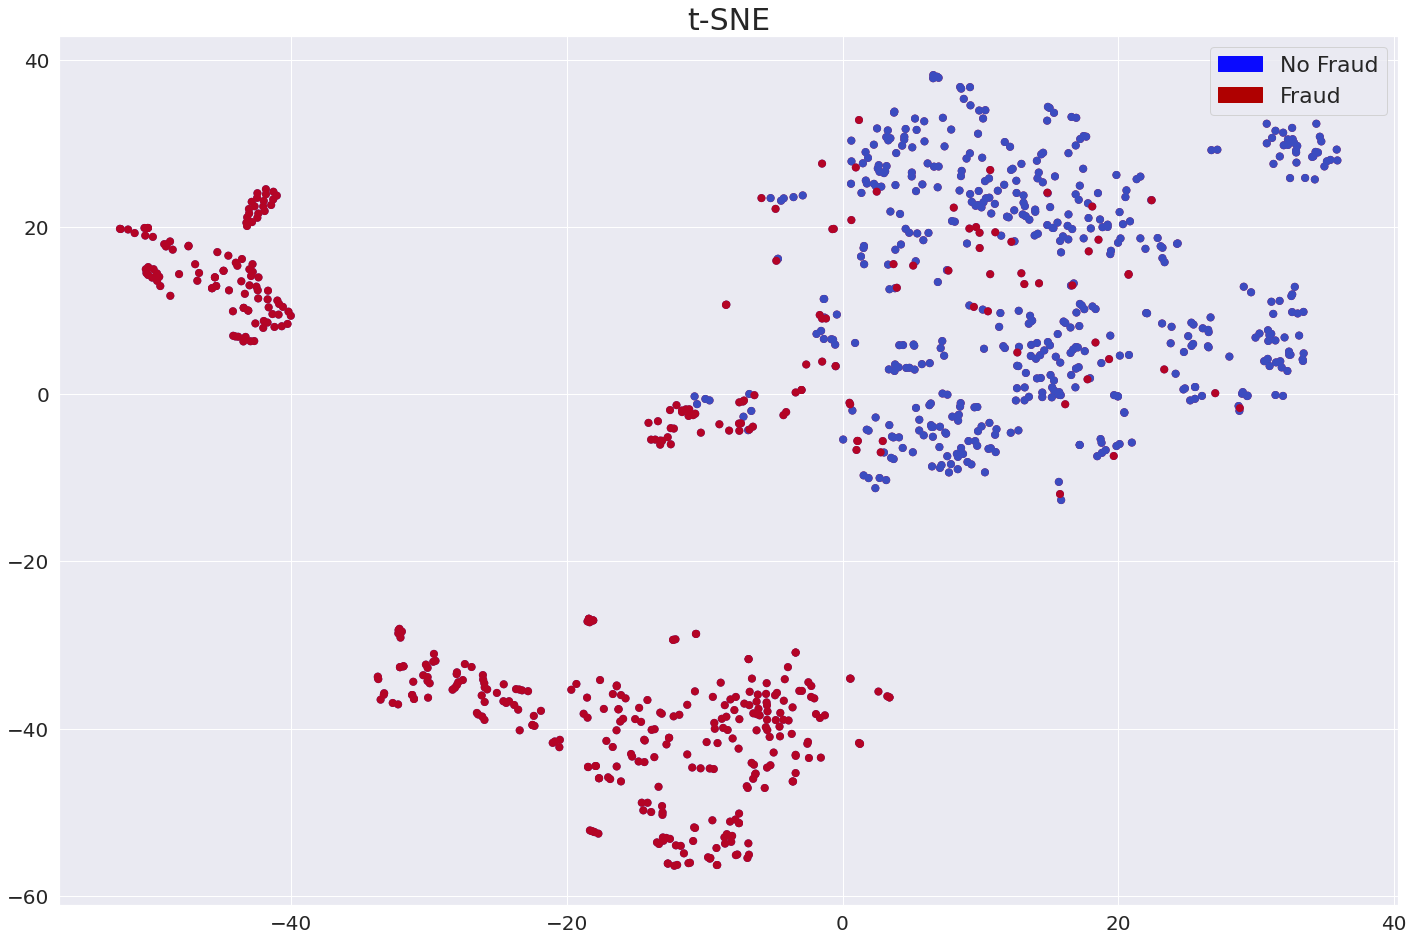

In [18]:
x_reduced = reduce_dimensionality(X)
plot(x_reduced, y)

Como podemos ver hay una clara diferencia con el grafico t-SNE anterior a procesar y normalizar el conjunto de datos, viendose claramente los clusteres mejor marcados.

Con esto bastaria para mejorar el modelo de clasficacion, aunque se pueden eliminar valores atipicos de algunas variables. Este proceso se añadira en el futuro.

# **Ejecucion con preprocesamiento**

Para ver los resultados ejecutalos los modelos de clasficacion y posteriormente evaluaremos las matrices de confusion y las medidas de desempeño

Entrenando modelo con la tecnica Neural Network
Dibujando matrices de confusion para Neural Network
Entrenando modelo con la tecnica Random Forest
Dibujando matrices de confusion para Random Forest
Entrenando modelo con la tecnica KNN
Dibujando matrices de confusion para KNN
Entrenando modelo con la tecnica Support Machine Vector
Dibujando matrices de confusion para Support Machine Vector
Entrenando modelo con la tecnica Logistic Regression
Dibujando matrices de confusion para Logistic Regression




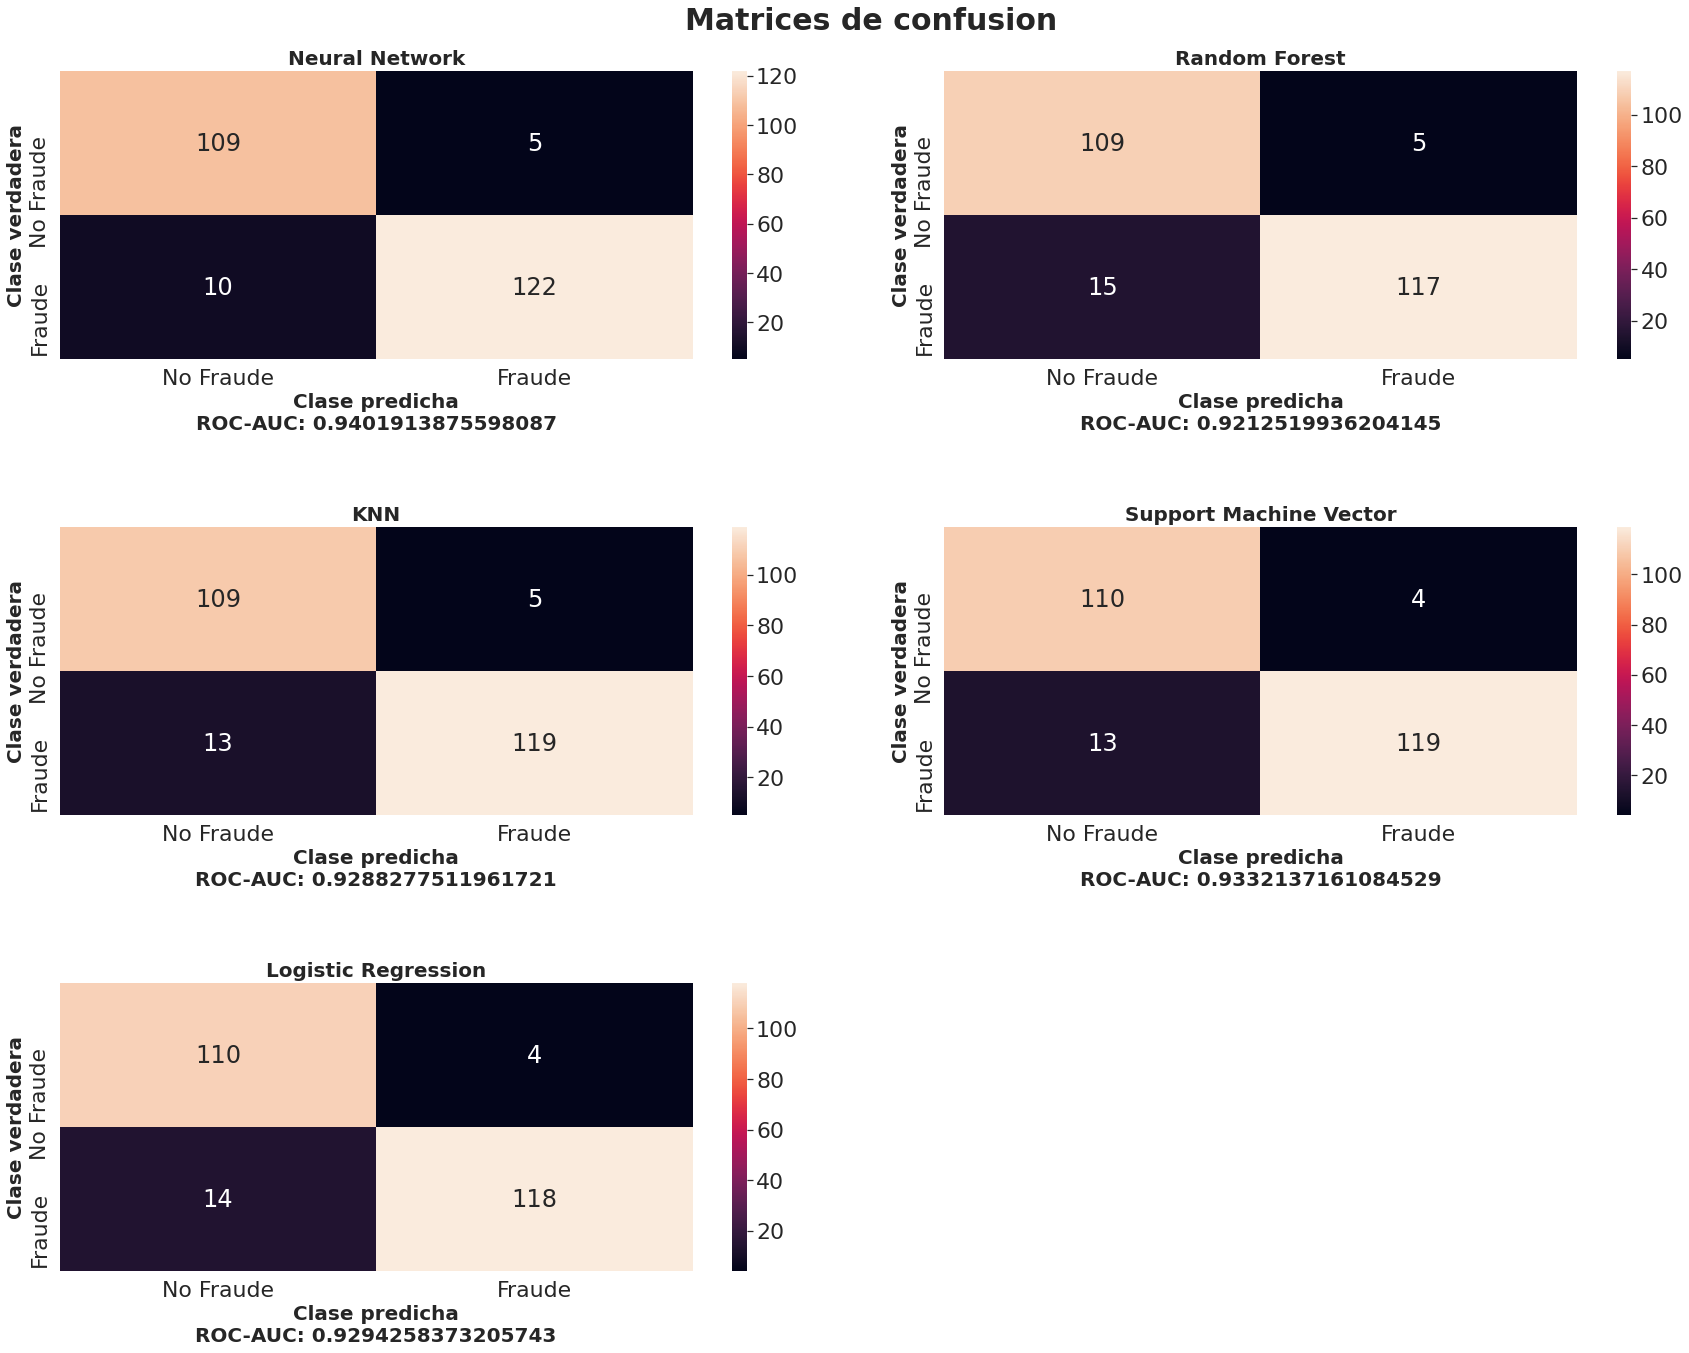


Method                    Accuracy    Precision    Recall    f1 Score    ROC AUC
----------------------  ----------  -----------  --------  ----------  ---------
Neural Network            0.939024     0.939024  0.939024    0.93909    0.940191
Random Forest             0.918699     0.918699  0.918699    0.918807   0.921252
KNN                       0.926829     0.926829  0.926829    0.926926   0.928828
Support Machine Vector    0.930894     0.930894  0.930894    0.930987   0.933214
Logistic Regression       0.926829     0.926829  0.926829    0.926926   0.929426


In [19]:
#Entrenar los modelos con el dataset procesado y normalizado
train(X, y)

# **Autoencoders**

Los autoencoders es un tipo de red neuronal el cual se utiliza para reducir informacion de un conjunto de datos o de una imagen. Es un algoritmo semi-supervisado, y por si solo puede llegar a clasificar correctamente y tener buenos resultados.

Esta tecnica tambien se utiliza para reducir informacion innecesaria en una iamgen, para mejorar su procesamiento y recursos computaciones para procesarla y extraer caracteristicas.

![Topologia de un Autoencoder](https://miro.medium.com/max/1222/1*CMWwGHbuf_T1b7Lon-8HAQ.png)

Para este proyecto se utilizara el autoencoder para reducir informacion innecesaria en el conjunto de datos. El peligro de esto es que llegue a reducir demasiada informacion, provocando perdida y haciendo que el modelo ya no sea tan eficiente.

Para implementarlo se utiliza `tensorflow-keras`. Se puede utilizar tanto la libreria para ejecutarlo en CPU como en GPU.

La topologia constara con 31 capas de entrada, seguida de 14 capas de entrada, seguido de 7 capas, para la parte de decodificacion se utilizara la topologia espejo, con la diferetnecia de que la salida tendra una funcion de activacion reLu.

El optimizador o la resolucion sera adadelta y la funcion de perdida sera MSE (Error cuadratico medio).

In [0]:
def autoencoding(X, y):
    ## Capas de entrada
    input_layer = Input(shape=(X.shape[1],))

    ## Parte de encoding
    encoded = Dense(14, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoded = Dense(7, activation='tanh')(encoded)
    ## Parte de decodificacion
    decoded = Dense(7, activation='tanh')(encoded)
    decoded = Dense(14, activation='tanh')(decoded)

    ## Capa de salida
    output_layer = Dense(X.shape[1], activation='relu')(decoded)

    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer="adadelta", loss="mse")

    return autoencoder

In [0]:
#Agregamos el modelo a la lista de algoritmos de modelos
algs.append(['AutoEncoding', autoencoding(X, y)])

Entrenando modelo con la tecnica Neural Network
Dibujando matrices de confusion para Neural Network
Entrenando modelo con la tecnica Random Forest
Dibujando matrices de confusion para Random Forest
Entrenando modelo con la tecnica KNN
Dibujando matrices de confusion para KNN
Entrenando modelo con la tecnica Support Machine Vector
Dibujando matrices de confusion para Support Machine Vector
Entrenando modelo con la tecnica Logistic Regression
Dibujando matrices de confusion para Logistic Regression
Entrenando modelo con la tecnica AutoEncoding
Train on 590 samples, validate on 148 samples
Epoch 1/100
590/590 [==============================] - 2s 3ms/step - loss: 14.3548 - val_loss: 11.9345
Epoch 2/100
590/590 [==============================] - 0s 34us/step - loss: 14.2915 - val_loss: 11.8873
Epoch 3/100
590/590 [==============================] - 0s 33us/step - loss: 14.2279 - val_loss: 11.8405
Epoch 4/100
590/590 [==============================] - 0s 36us/step - loss: 14.1792 - val_loss:

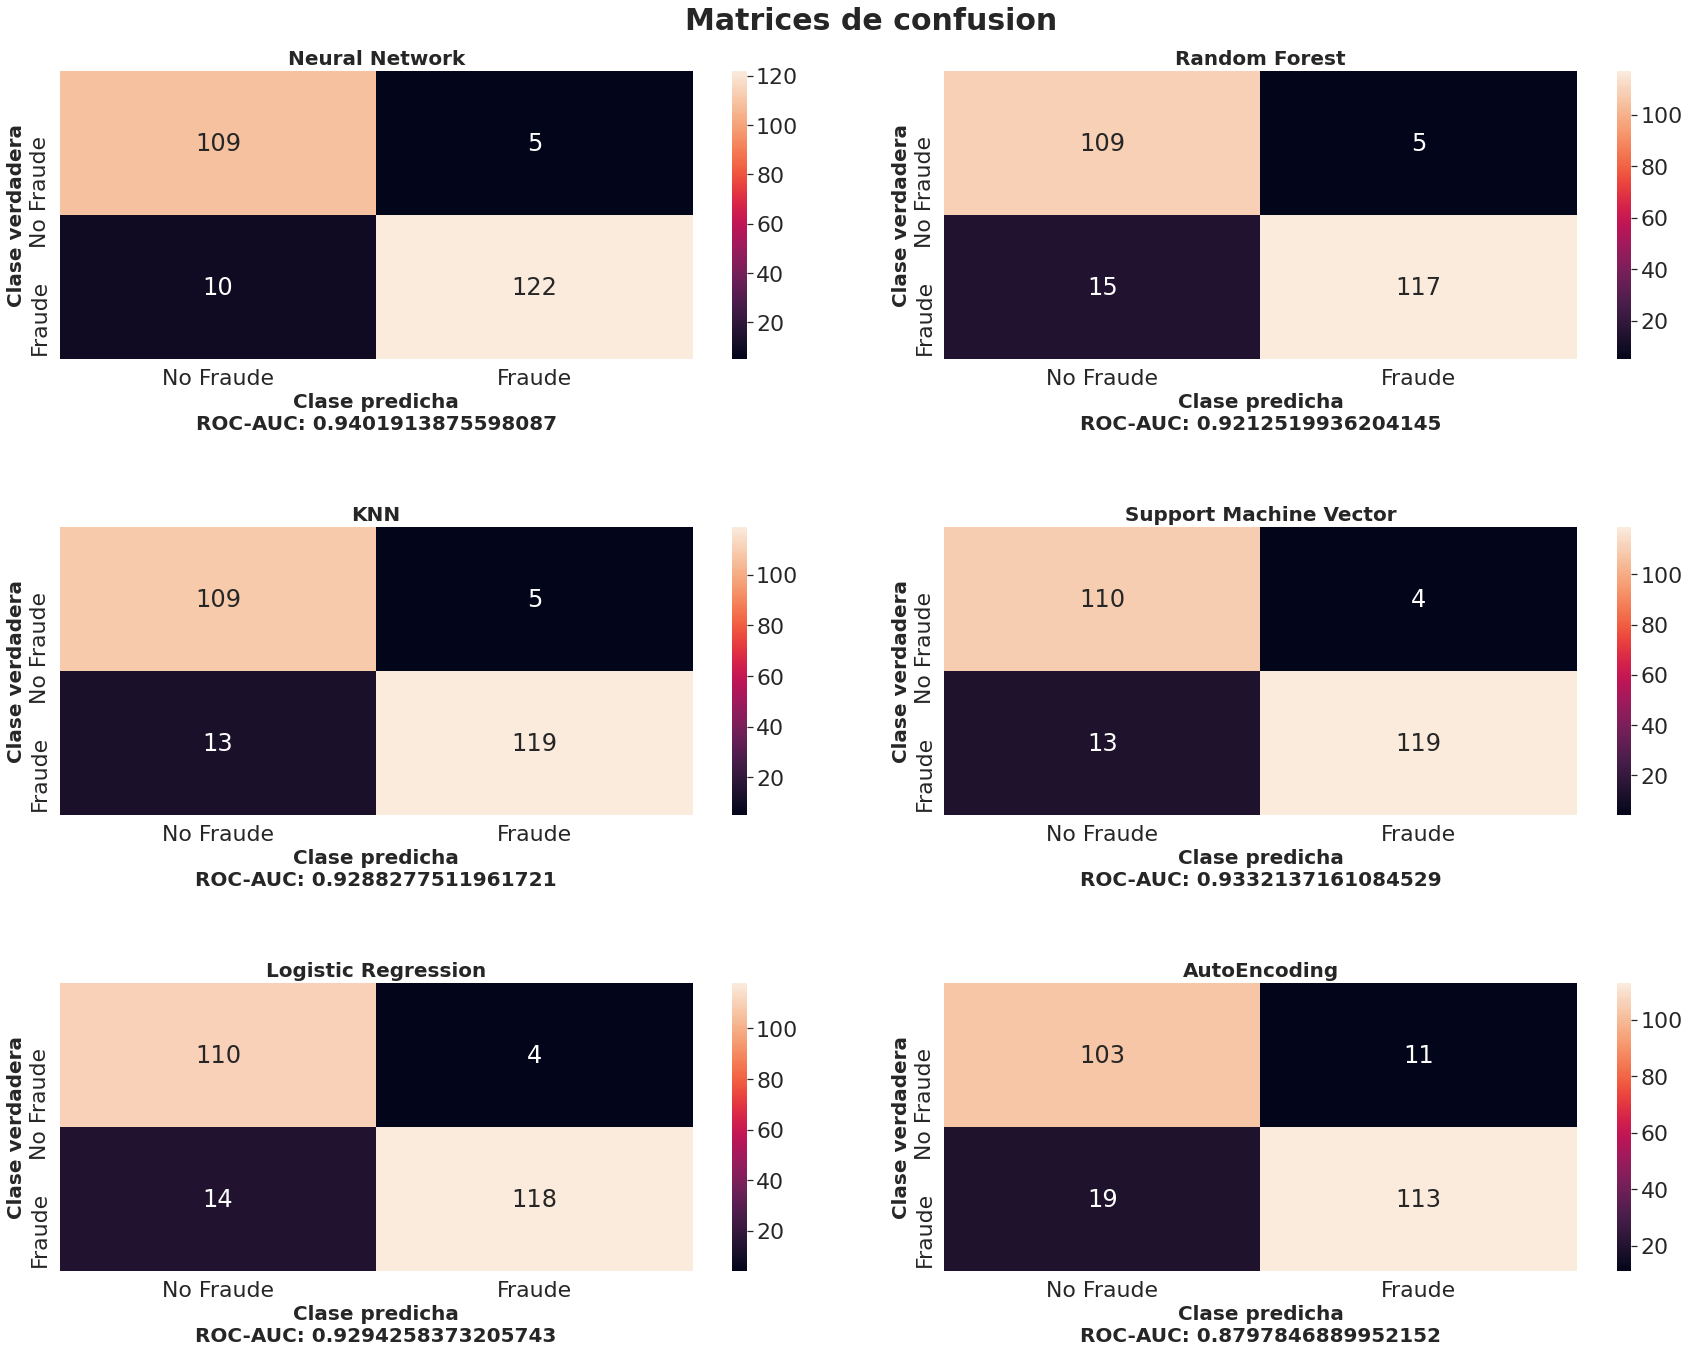


Method                    Accuracy    Precision    Recall    f1 Score    ROC AUC
----------------------  ----------  -----------  --------  ----------  ---------
Neural Network            0.939024     0.939024  0.939024    0.93909    0.940191
Random Forest             0.918699     0.918699  0.918699    0.918807   0.921252
KNN                       0.926829     0.926829  0.926829    0.926926   0.928828
Support Machine Vector    0.930894     0.930894  0.930894    0.930987   0.933214
Logistic Regression       0.926829     0.926829  0.926829    0.926926   0.929426
AutoEncoding              0.878049     0.878049  0.878049    0.87821    0.879785


In [22]:
#Entrenamos todos los modelos, incluyendo el AutoEncoding
train(X, y)

Si bien el AutoEncoding da buenos resultados esta un poco por debajo de las otras tecnicas de ML de clasificacion. Ajustando la tiopologia y las funciones de activacion se podria llegar a un mejor resultado.